In [1]:
import pandas as pd
import numpy as np
import collections
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [36]:
#______________________________________________________________________
from io import StringIO
dataset=pd.read_csv('drug_analysis.csv', error_bad_lines=False)
pd.set_option('display.max_colwidth', -1)
df = dataset[~dataset["condition"].str.contains("</span> users found this comment helpful.", na=False)]
#train, val, test = np.split(df.sample(frac=1), [int(.3*len(df)), int(.9*len(df))])
#df = train[~train["condition"].str.contains("</span> users found this comment helpful.", na=False)]
df = dataset[~dataset["condition"].str.contains("</span> users found this comment helpful.", na=False)]
col = ['condition', 'review']
df = df[col]
df = df[pd.notnull(df['review'])]
df.columns = ['condition', 'review']
df = df.dropna()
df['condition'] = df['condition'].str.replace('eve','fever')
df = df[(df.condition == 'fever')]

df['category_id'] = df['condition'].factorize()[0]
df

,condition,review,category_id
16562,fever,"""I always use Tylenol when my kids have a fever, it works great!""",0
20077,fever,"""It&#039;s awesome.""",0
61494,fever,"""Had high fever, took 2 Tylenol extra strength and fever broke within 1/2 hour. You&#039;ll sweat a lot as fever breaks but that&#039;s normal per my doctor.""",0
65145,fever,"""My son has had a lo-grade fever for three days. I&#039;ve had him on Tylenol every 4 hours but decided to try Motrin instead during his regular dosing schedule. It didn&#039;t do a thing. His fever kept rising. Tylenol is the only thing that has worked for him.""",0
69737,fever,"""Gels are better and work faster than the tablet form.""",0
103056,fever,"""Gels are better and work faster than the tablet form.""",0
107537,fever,"""I purchased this medicine for my little girl because it was doctor recommended. It was a need base purchase to reduce her fever and some of the discomfort that she was having. They stated that it would be the best in reducing her fever. I purchased the medicine and shortly after her fever was gone and she was resting. She slept well through the night. Children%u2019s Motrin is a name that I trust. Therefore, I was not hesitant at all when my doctor recommended that I purchase this product. I have also used other fever reducer products for my little one, such as Tylenol and it did not reduce her fever at all, so Motrin was the choice brand. Motrin allowed her to sleep through the night and she did not spike a fever the next day. Motrin did the job.""",0
107707,fever,"""Pain: not very effective. No side effects, easy to use.\r\nFever: definitely a 10. Always helps.\r\nThis got a high rating due to the fever-reducing.""",0
113471,fever,"""Pain: not very effective. No side effects, easy to use.\r\nFever: definitely a 10. Always helps.\r\nThis got a high rating due to the fever-reducing.""",0
119250,fever,"""Works great as a fever reducer.""",0


In [5]:
#category_id_df = df[['condition', 'category_id']].drop_duplicates().dropna().sort_values('category_id')
#category_to_id = dict(category_id_df.values)
#id_to_category = dict(category_id_df[['category_id', 'condition']].values)

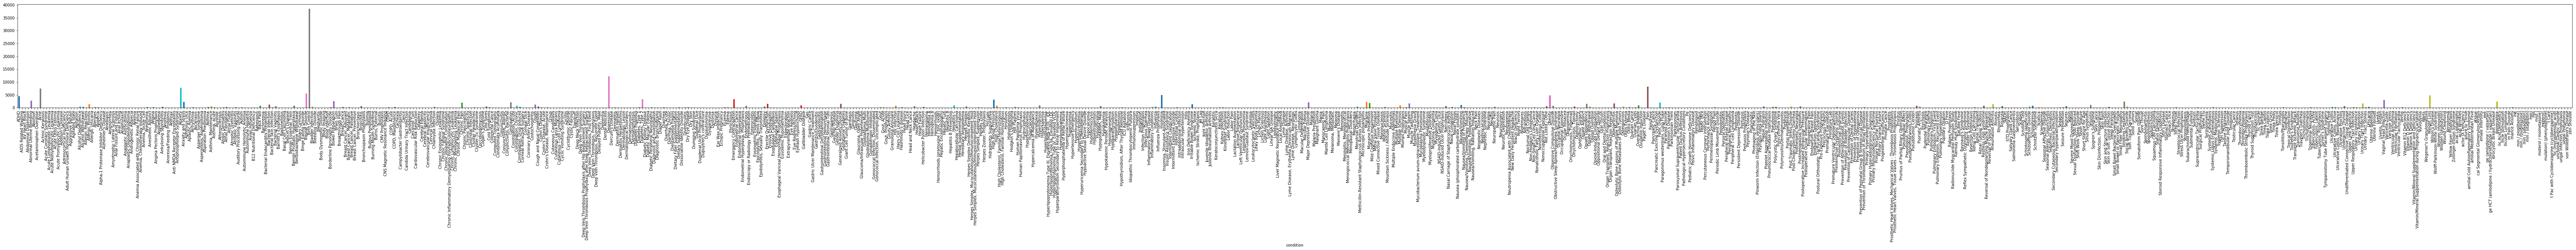

In [6]:
fig = plt.figure(figsize=(120,5))
df.groupby('condition').review.count().plot.bar(ylim=0)
plt.show()

In [8]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['condition'], random_state = 0)
#count_vect = StemmedCountVectorizer(stop_words='english')
count_vect = StemmedCountVectorizer("english")
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(159523, 36239)

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(159523, 36239)

In [192]:
from sklearn.naive_bayes import MultinomialNB
import time
start = time.time()

clf = MultinomialNB().fit(X_train_tfidf, y_train)
#text_clf = text_clf.fit(X_train, y_train)
predicted = clf.predict(X_train_tfidf)
print(np.mean(predicted == y_train))
"the code you want to test stays here"
end = time.time()
print ("time taken")
print(end - start)

ModuleNotFoundError: No module named 'sklearn'

In [9]:
#clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [10]:
print(clf.predict(tfidf_transformer.transform(count_vect.transform(["I know why im hungry all the time and I am gaining weight"]))))

['Birth Control']


In [11]:
print(clf.predict(tfidf_transformer.transform(count_vect.transform(["I started to get panic attacks"]))))

['Anxiety']


In [12]:
from sklearn.linear_model import SGDClassifier
import time
start = time.time()


text_clf_svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=20, tol=0.0, random_state=42).fit(X_train_tfidf, y_train)
predicted_svm = text_clf_svm.predict(X_train_tfidf)
print(np.mean(predicted_svm == y_train))

end = time.time()
print ("time taken")
print(end - start)

/home/vikmachine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.6847476539433185
time taken
751.0371370315552


In [13]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform(["I have a lot of stomach pain today"]))))

['Osteoarthritis']


In [14]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform(["I started to get panic attacks"]))))

['Panic Disorde']


In [15]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform(["I know why im hungry all the time and I am loosing weight"]))))

['Obesity']


In [16]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform([" I slept well last night and and I start my day early everyday now"]))))

['HIV Infection']


In [17]:
from sklearn.neighbors import KNeighborsClassifier as knn
#text_clf_svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=10, tol=0.0, random_state=42)),])
start = time.time()
#text_clf_svm.fit(X_train, y_train)
text_clf_svm = knn().fit(X_train_tfidf, y_train)
predicted_svm = text_clf_svm.predict(X_train_tfidf)
print(np.mean(predicted_svm == y_train))
end = time.time()
print ("time taken")
print(end - start)

0.6748932755778164
time taken
1999.6692488193512


In [18]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform(["I have a lot of stomach pain today"]))))

['Bronchitis']


In [19]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform(["I started to get panic attacks"]))))

['Depression']


In [20]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform(["I know why im hungry all the time and I am loosing weight"]))))

['HIV Infection']


In [21]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform(["Been a heavy beer and wine drinker everyday "]))))

['Alcohol Dependence']


In [8]:
from sklearn.svm import LinearSVC
import time
start = time.time()

text_clf_svm= LinearSVC().fit(X_train_tfidf, y_train)
predicted = text_clf_svm.predict(X_train_tfidf)
print(np.mean(predicted == y_train))

end = time.time()
print ("time taken")
print(end - start)

0.9141941914332102
time taken
299.3262641429901


In [130]:
classify_now("I used to be hungry all the time but now I am loosing weight")

"'Obesity'"

In [21]:
classify_now(" Have Been a heavy beer and wine drinker and I still am")

['your Condition was [ Alcohol Dependence ]']


In [22]:
classify_now(" I slept well last night for a change")

['your Condition was [ Insomnia ]']


In [24]:
classify_now("I am having terrible mood swings and my periods are getting worse")

['your Condition was [ Birth Control ]']


In [28]:
from sklearn import tree #decision trees

start = time.time()
text_clf_dtree = tree.DecisionTreeClassifier().fit(X_train_tfidf, y_train)
predicted = text_clf_dtree.predict(X_train_tfidf)
print(np.mean(predicted == y_train))

end = time.time()
print ("time taken")
print(end - start)

0.9956244554076842
time taken
1249.3679404258728


In [29]:
print(text_clf_dtree.predict(tfidf_transformer.transform(count_vect.transform(["I was having a lot of stomach pain"]))))

['Bronchitis']


In [30]:
print(text_clf_dtree.predict(tfidf_transformer.transform(count_vect.transform(["I started to get panic attacks"]))))

['Bipolar Disorde']


In [31]:
print(text_clf_dtree.predict(tfidf_transformer.transform(count_vect.transform(["I know why im hungry all the time and I am loosing weight"]))))

['Weight Loss']


In [32]:
print(text_clf_dtree.predict(tfidf_transformer.transform(count_vect.transform(["Been a heavy beer and wine drinker everyday "]))))

['Asthma']


In [33]:
print(text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform([" I slept well last night and and I start my day early now"]))))

['Diabetes, Type 2']


In [ ]:
from sklearn.svm import LinearSVC
import time
start = time.time()

text_clf_svm= LinearSVC().fit(X_train_tfidf, y_train)
predicted = text_clf_svm.predict(X_train_tfidf)
print(np.mean(predicted == y_train))

end = time.time()
print ("time taken")
print(end - start)

In [145]:
f1 = pd.read_csv("/home/vikmachine/drugsComTrain_raw.csv", error_bad_lines=False)
f2 = pd.read_csv("/home/vikmachine/drugsComTest_raw.csv", error_bad_lines=False)


In [11]:
k=pd.DataFrame(f1)
k1=pd.DataFrame(f2)
k3 = pd.concat([k, k1], ignore_index=True)
f3=pd.DataFrame(k3)
f3

NameError: name 'f1' is not defined

In [2]:
f3=pd.read_csv('drug_analysis.csv', error_bad_lines=False)

In [3]:
#def get_drugs(cond):

In [4]:
d=f3['drugName']
c=f3['condition']
r=f3['rating']

In [5]:
datalist =[]
for l in range(0,len(f3)):
    datalist.append({d[l],c[l]})
ulist=[]
for n in range(0,len(f3)):
    if datalist[n] not in ulist:
        ulist.append(datalist[n])

In [6]:
m = 0
result = {}
while m < len(f3):
        d3 = d[m]
        c3 = c[m]
        rating = r[m]
        if {d3,c3} in ulist:
            #result.append({d3,c3,rating})
            try:
                result[d3,c3].append(rating)
            except KeyError:
                result[d3,c3] = [rating]
            
        m = m+1 

In [7]:
result2 = {}
for key in result:
    result2[key] = sum(result[key])


In [8]:
leng={}
for key in result:
        leng[key] = len(result[key])


In [9]:
result3 = {}
for key in result:
    result3[key] = (sum(result[key]))/(len(result[key]))


In [10]:
keys = [ k for k in result3 ]
vals = list_values = [ v for v in result3.values() ]


In [11]:
dd=[]
cc=[]
for (i,m) in keys:
    dd.append(i)
    cc.append(m)


In [12]:
dff = pd.DataFrame()

dff['Drug'] = dd
dff['condition'] = cc

dff['Average_rating'] = vals


In [13]:
dff = dff[~dff["condition"].str.contains("</span> users found this comment helpful.", na=False)]

dff = dff.dropna()
dff = dff.reset_index()

In [14]:
dff = dff.drop(['index'], axis=1)
#dff.to_csv('new.csv', sep=',')

In [15]:
dff=dff.sort_values(by=['condition','Average_rating'], ascending=[True,False])
dff = dff[~dff["condition"].str.contains("</span> users found this comment helpful.", na=False)]
dff

,Drug,condition,Average_rating
2997,ProCentra,ADHD,10.000000
6795,Selegiline,ADHD,10.000000
8366,Dextrostat,ADHD,10.000000
915,Desoxyn,ADHD,9.631579
1302,Pemoline,ADHD,9.571429
4891,Cylert,ADHD,9.571429
2862,Catapres,ADHD,9.333333
2947,Ritalin LA,ADHD,9.200000
6508,Provigil,ADHD,9.200000
3679,Wellbutrin XL,ADHD,8.909091


In [30]:
def get_drugs(cond):
    cond_dff = pd.DataFrame()
    cond_dff = dff[(dff.condition == cond)]
    cond_dff = cond_dff.drop(columns=['condition']).reset_index()
    cond_dff = cond_dff.drop(columns=['index'])
    if len(cond_dff) < 10:
        cond_dff = cond_dff.head(len(cond_dff))
    else:
        cond_dff = cond_dff.head(10) 
    print(cond_dff)

In [31]:
get_drugs('Birth Control')

                    Drug  Average_rating
0                Elinest       10.000000
1                 Plan B       10.000000
2        Low-Ogestrel-21       10.000000
3           Zovia 1 / 50       10.000000
4                Heather        9.750000
5              Emoquette        9.000000
6               Ovcon 35        8.750000
7  Ortho-Novum 7 / 7 / 7        8.666667
8                Caziant        8.500000
9              Femcon Fe        8.375000


In [ ]:
def classify_now(x):
    y=text_clf_svm.predict(tfidf_transformer.transform(count_vect.transform([x])))
    y= ", ".join( repr(e) for e in y)
    return y

In [ ]:
y=classify_now("I am having terrible mood swings and my periods are getting worse")
y=y.strip('\'')
y

In [ ]:
print(xx[y])